# Controlador de vuelo para vehículos aéreos no tripulados multi-rotor basado en técnicas de aprendizaje profundo

## Análisis del Dataset

### Javier Cárdenas - Uriel Carrero

## 1. Descripción del Dataset

#### Importar Librerías

In [1]:
import os
import sys
sys.path.append('../scripts/')
import random
import csv

import matplotlib.pyplot as plt     # Gráficos
from matplotlib.colors import LogNorm
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None) #Para mostrar todas las columnas

import numpy as np                  # Cómputo Numérico
print(np.__version__)
#assert (np.__version__=='1.19.5'), 'Versión incorrecta de numpy, por favor instale 1.19.5'
seed = 5
np.random.seed(seed)
np.seterr(divide = 'ignore')

from utils import *

1.19.5


In [2]:
import gc #garbage collector
import gc; gc.enable()

### Leemos el Dataset

In [3]:
root = '../logs/Datasets/'
dataset_name = 'Dataset_Final'
#dataset_name = 'DatasetPSO_XYZ+XYRG_TYaw_PS'
rootdir = root+dataset_name
ext_csv = False
if not os.path.exists(rootdir):
    print(f"{rootdir} not exist")

#### Obtener lista de entradas (estados) y salidas (acciones)

In [4]:
df = pd.read_csv(os.path.join(rootdir, random.choice(os.listdir(rootdir))))
delete_list = ['timestamps',
               'Q1', 'Q2', 'Q3', 'Q4', 
               'uvx', 'uvy', 'uvz', 
               'up', 'uq', 
               'uwp', 'uwq', 'uwr']
df_list = df.columns.to_list()
rpm_list = [i for i in df_list if ("RPM" in i)]
states_list = [i for i in df_list if not ((i in delete_list) or (i in rpm_list))]
Ts = df['timestamps'][1]-df['timestamps'][0]
fs = 1/Ts

#### Matlab

In [5]:
# df = pd.read_csv(os.path.join(rootdir, random.choice(os.listdir(rootdir))))
# Ts = df['Time'][1]-df['Time'][0]
# fs = 1/Ts
# delete_list =['Time', 'Bat_V','Bat_Percentage','P_r', 'Q_r', 'R_r', 'Flag_Pitch_Roll','Ac_Dx', 'Ac_Dy', 'Ac_Dz','Sonar Altitud','Pressure Altitud', 'Acceleracion P', 'Acceleracion Q', 'Acceleracion R']+['Yaw_r', 'Pitch_r','Roll_r']
# df_list = df.columns.to_list()
# rpm_list = [i for i in df_list if ("Motor" in i)]
# states_list = [i for i in df_list if not ((i in delete_list) or (i in rpm_list))]

#### Desplazar estados de RPM (solo se hace 1 vez en todo el dataset)
Los estados que guarda Pybullet no es el RPM actual, sino el anterior, por lo que hay que desplazar los estados

In [6]:
# for filename in os.listdir(rootdir):
#     if not filename.endswith(".csv"):
#         continue
#     df = pd.read_csv(os.path.join(rootdir, filename))
#     if any(abs(df['vz'])>=10) or any(abs(df['p'])>=0.6) or any(abs(df['q'])>=0.6) or any(df['uz']<0) or any(df['z']<0): #Eliminar si el dron se cae o la referencia de z es negativa
#         print(filename)
#     else:
#         if any(df[rpm_list].loc[0]==0): #Desplazar los estados de RPM si es necesario
#             df[rpm_list] = df[rpm_list].shift(periods=-1)
#             df = df.dropna()
#             df.to_csv(os.path.join(rootdir, filename), index=False)

### Tipos de Trayectorias

In [7]:
traj_dict={'r': Counter(), 'x':Counter(), 'y':Counter(), 'z':Counter()}

N = len(os.listdir(rootdir))
for filename in os.listdir(rootdir):
    if not filename.endswith(".csv"):
        continue

    file = ''.join(i for i in filename if not i.isdigit())
    file.replace(' ', '')
    file = file.split('-')
    for f in file:
        names=f.split('_', 1)
        if len(names)==2:
            traj_dict[names[0]].add(names[1])

for key in traj_dict.keys():
    l = sum(traj_dict[key].dict.values())
    if l<N:
        for _ in range(N-l):
            traj_dict[key].add('stopped')
            
for key in traj_dict.keys():
    traj_dict[key] = traj_dict[key].dict
    
traj_count = pd.DataFrame(traj_dict, columns=traj_dict.keys())
traj_count = traj_count.fillna(0).astype(np.int)
traj_count = traj_count.reindex(traj_count.sum(axis=1).sort_values(ascending=False).index.str.strip())
traj_count['total'] = traj_count.sum(axis=1)
traj_count

,r,x,y,z,total
stopped,100,47,57,45,249
random_step,53,61,63,66,243
step_notret,3,23,17,20,63
noise,4,7,8,19,38
step_ret,4,15,6,11,36
big_step_notret,1,9,10,3,23
ramp,4,0,0,4,8
sin,0,3,4,0,7
chirp_amplin,0,2,2,0,4
lemniscate,0,2,2,0,4


In [8]:
traj_count_2 = traj_count.rename(index={"stopped": "Quieto", "random_step": "Paso Aleatorio", 
                         "step_notret": "Paso no retorno a 0", "noise": "ruido",
                        "step_ret": "Paso retorno a 0", "big_step_notret": "Paso Intercalado",
                         "chirp_amplin": "Barrido frecuencia", "ramp":"Rampa"}, columns = {"r": "$\psi$"})
traj_count_2

,$\psi$,x,y,z,total
Quieto,100,47,57,45,249
Paso Aleatorio,53,61,63,66,243
Paso no retorno a 0,3,23,17,20,63
ruido,4,7,8,19,38
Paso retorno a 0,4,15,6,11,36
Paso Intercalado,1,9,10,3,23
Rampa,4,0,0,4,8
sin,0,3,4,0,7
Barrido frecuencia,0,2,2,0,4
lemniscate,0,2,2,0,4


<Figure size 432x288 with 0 Axes>

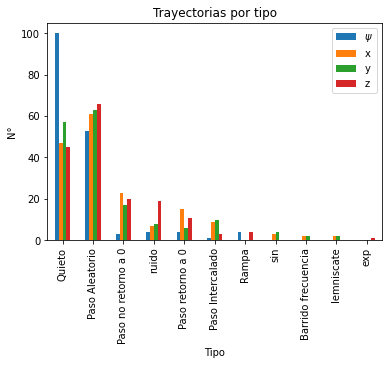

In [9]:
plt.figure()
traj_count_2.loc[:,:'z'].plot.bar()
plt.ylabel(f'N°')
plt.title(f'Trayectorias por tipo')
plt.xlabel('Tipo')
plt.savefig("../Imágenes/Dataset/Trajectories_type.svg", format='svg', bbox_inches='tight')

#### Visualización temporal y frecuencial de los tipos de señales

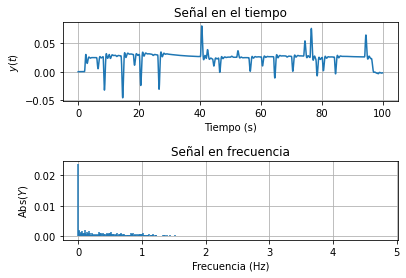

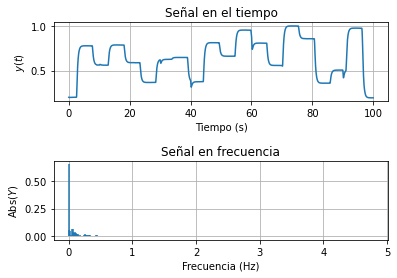

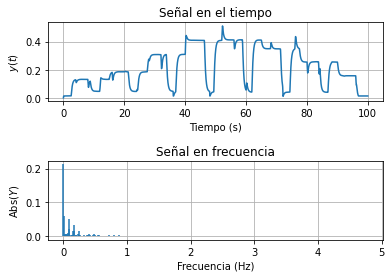

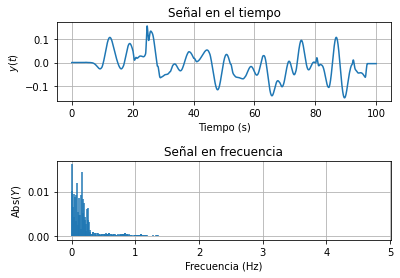

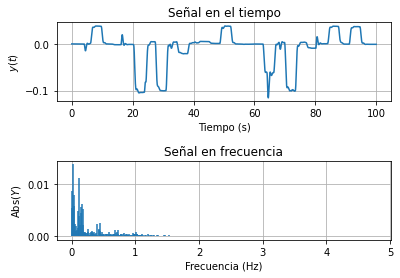

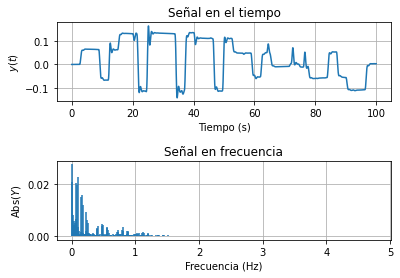

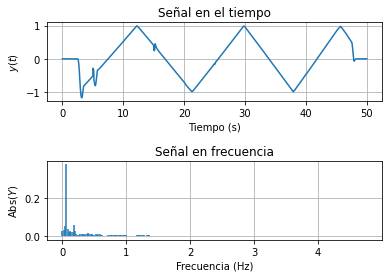

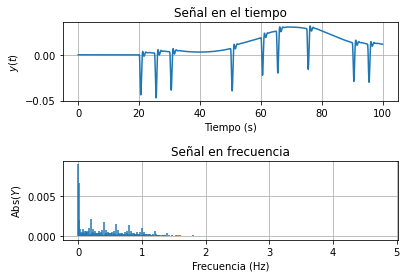

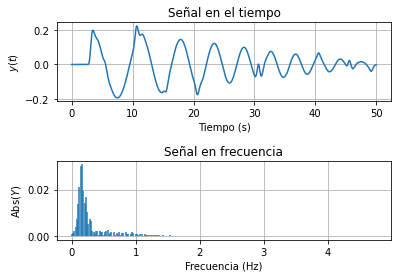

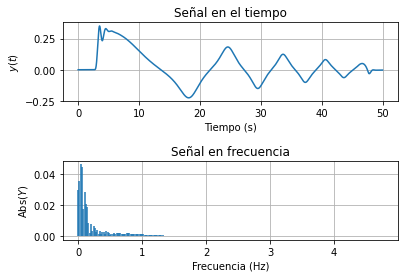

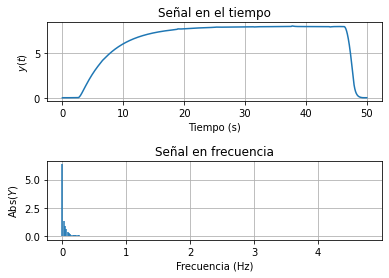

In [10]:
listdir = os.listdir(rootdir)
for t in traj_count.index:
    random.shuffle(listdir)
    for filename in listdir:
        if t in filename:
            state = [n[0] for n in filename.split('-') if t in n][0]
            df = pd.read_csv(os.path.join(rootdir, filename))
            _=plot_fourier(df[state].to_numpy(), fs, t+'_'+state)
            plt.savefig(f"../Imágenes/Dataset/{t}_type.svg", format='svg', bbox_inches='tight')
            break

### Descripción del dataset

#### Descripción por variables

In [11]:
dfs = []
for filename in os.listdir(rootdir):
    if not filename.endswith(".csv"):
        continue
    df = pd.read_csv(os.path.join(rootdir, filename))
    df =  df.drop(delete_list, axis=1)
    dfs.append(df)
df_desc = pd.concat(dfs)
df_desc = df_desc.describe()
#df_desc['z']['max']=4
#df_desc['uz']['max']=4
df_desc

,x,y,z,p,q,r,vx,vy,vz,wp,wq,wr,ax,ay,az,ap,aq,ar,RPM0,RPM1,RPM2,RPM3,ux,uy,uz,ur
count,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06
mean,6.352137e-03,3.631930e-03,8.701060e-01,8.113104e-04,7.632901e-04,1.239124e-02,-1.253432e-04,-2.641033e-04,1.198860e-03,4.372706e-06,1.434372e-04,2.558978e-03,-1.772714e-05,3.597617e-05,-2.469848e-05,1.224907e-04,5.466858e-05,-3.303912e-05,1.441162e+04,1.441290e+04,1.440977e+04,1.441093e+04,6.439717e-03,3.417250e-03,8.782731e-01,1.285404e-02
std,1.067096e-01,1.015022e-01,7.571069e-01,3.005110e-02,3.288610e-02,4.450773e-01,7.177616e-02,6.552093e-02,2.601583e-01,1.942947e-01,2.135545e-01,5.107082e-01,3.168708e-01,2.945918e-01,1.454656e+00,7.742095e+00,6.830287e+00,3.325449e+00,1.055152e+03,1.058528e+03,1.058532e+03,1.058966e+03,1.058331e-01,1.010920e-01,7.641660e-01,4.414466e-01
min,-8.166897e-01,-8.176113e-01,2.113373e-04,-4.872289e-01,-4.386099e-01,-3.141419e+00,-1.156056e+00,-8.621260e-01,-6.841123e+00,-1.045986e+01,-7.981405e+00,-7.181414e+00,-4.279933e+01,-3.656422e+01,-9.800000e+00,-2.510366e+03,-3.059815e+03,-2.531001e+02,9.440300e+03,9.440300e+03,9.440300e+03,9.440300e+03,-8.000000e-01,-8.000000e-01,0.000000e+00,-3.140685e+00
25%,-7.023093e-03,-4.566531e-03,3.597720e-01,-7.548420e-04,-1.295726e-03,-3.379343e-04,-2.080171e-03,-1.373874e-03,-1.070760e-02,-5.708022e-03,-8.702793e-03,-6.507613e-05,-1.356462e-02,-7.912034e-03,-4.078746e-02,-4.151471e-02,-6.752393e-02,-2.696169e-04,1.438274e+04,1.438057e+04,1.438241e+04,1.437958e+04,0.000000e+00,0.000000e+00,3.549988e-01,0.000000e+00
50%,9.264773e-05,8.164912e-06,9.371726e-01,0.000000e+00,2.258764e-17,0.000000e+00,-1.518968e-08,1.364815e-17,3.785519e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.865757e-05,0.000000e+00,0.000000e+00,0.000000e+00,1.446835e+04,1.446836e+04,1.446834e+04,1.446834e+04,0.000000e+00,0.000000e+00,9.364582e-01,0.000000e+00
75%,2.154385e-02,1.321506e-02,1.092425e+00,9.607826e-04,1.469981e-03,5.312049e-04,2.095210e-03,1.519517e-03,1.501362e-02,5.440229e-03,8.939743e-03,3.879907e-05,1.237756e-02,8.299066e-03,3.374101e-02,4.180967e-02,6.758204e-02,3.539114e-04,1.452948e+04,1.453062e+04,1.452831e+04,1.452817e+04,1.838854e-02,8.750144e-03,1.144531e+00,0.000000e+00
max,8.194435e-01,8.146467e-01,8.073860e+00,3.767827e-01,4.339304e-01,3.141577e+00,8.494385e-01,8.597021e-01,6.373837e+00,7.147506e+00,1.179763e+01,7.300762e+00,3.906528e+01,3.332884e+01,1.921161e+02,2.711637e+03,2.831431e+03,1.630572e+02,2.166645e+04,2.166645e+04,2.166645e+04,2.166645e+04,8.000000e-01,8.000000e-01,7.998727e+00,3.141519e+00


In [12]:
control_list = ['ux','uy', 'uz', 'ur']
df_desc[control_list]

,ux,uy,uz,ur
count,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06
mean,6.439717e-03,3.417250e-03,8.782731e-01,1.285404e-02
std,1.058331e-01,1.010920e-01,7.641660e-01,4.414466e-01
min,-8.000000e-01,-8.000000e-01,0.000000e+00,-3.140685e+00
25%,0.000000e+00,0.000000e+00,3.549988e-01,0.000000e+00
50%,0.000000e+00,0.000000e+00,9.364582e-01,0.000000e+00
75%,1.838854e-02,8.750144e-03,1.144531e+00,0.000000e+00
max,8.000000e-01,8.000000e-01,7.998727e+00,3.141519e+00


In [13]:
norm_data_path = f"{root}/data_description_{dataset_name}.csv"
df_desc.to_csv(norm_data_path, index=True)

#### Longitud de trayectorias

In [14]:
dataset = []
for filename in os.listdir(rootdir):
    if not filename.endswith(".csv"):
        continue
        
    df = pd.read_csv(os.path.join(rootdir, filename))
    df =  df.drop(delete_list, axis=1)
    x = df.drop(rpm_list, axis=1)
    y = df.drop(states_list, axis=1)
    dataset.append([x, y])

df = None
x = None
y= None

In [15]:
c = Counter()
for data in dataset:
    x, _ = data
    c.add(len(x))
c_hist = c.counts(desc=True)

x = []
y = [] 
for i in c_hist:
    x.append(str(np.round(i[1]*Ts)))
    y.append(i[0])

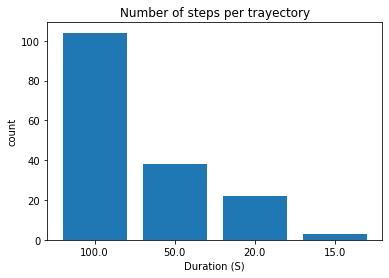

In [16]:
plt.bar(x, y, width = 0.8)
plt.title('Number of steps per trayectory')
plt.xlabel('Duration (S)')
plt.ylabel('count')
plt.show()

In [17]:
print(f'Dataset Size: {( ( (sys.getsizeof(dataset[0][0])+sys.getsizeof(dataset[0][1])) *len(dataset)/1024) /1024)/1024} GB')
print(f'Dataset len: {len(dataset)} Signals')
print(f'Inputs len: {len(states_list)}, Inputs: {states_list}')
print(f'Control len: {len(control_list)}, Inputs: {control_list}')
print(f'Outputs len: {len(rpm_list)}, Outputs: {rpm_list}')
print(f'Sample Time: {"{:.2f}".format(Ts*1000)} ms, Sample Freq: {"{:.2f}".format(1/Ts)} Hz')
print(f'Max Time Signal Duration: {"{:.2f}".format(c.counts(True)[0][1]*Ts)} s')
print(f'Min Time Signal Duration: {"{:.2f}".format(c.counts()[0][1]*Ts)} s')
print(f'Average Time Signal Duration: {"{:.2f}".format(c.mean()*Ts)} s')
print(f'Average Number of Samples per Signal: {"{:.0f}".format(c.mean())}')
print(f'Total Number of Samples: {"{:.0f}".format(c.total())}')

Dataset Size: 0.7764225453138351 GB
Dataset len: 167 Signals
Inputs len: 22, Inputs: ['x', 'y', 'z', 'p', 'q', 'r', 'vx', 'vy', 'vz', 'wp', 'wq', 'wr', 'ax', 'ay', 'az', 'ap', 'aq', 'ar', 'ux', 'uy', 'uz', 'ur']
Control len: 4, Inputs: ['ux', 'uy', 'uz', 'ur']
Outputs len: 4, Outputs: ['RPM0', 'RPM1', 'RPM2', 'RPM3']
Sample Time: 4.17 ms, Sample Freq: 240.00 Hz
Max Time Signal Duration: 100.00 s
Min Time Signal Duration: 15.00 s
Average Time Signal Duration: 76.55 s
Average Number of Samples per Signal: 18373
Total Number of Samples: 3068233


#### Histograma de estados en frecuencia

In [18]:
Fourier = []
for i, df in enumerate(dfs):
    n = len(df)
    Fourier.append({})
    for state in states_list:
        Fourier[i][state]={}
        Fourier[i][state]['Y'] = abs(fft(df[state].to_numpy())/n)[0:int(n/2)] # Transformada normalizada
        Fourier[i][state]['X'] = fftfreq(n, Ts)[0:int(n/2)]

In [19]:
F = {}
for state in states_list:
    F[state]={}
    F[state]['X'] = []
    F[state]['Y'] = []
    for f in Fourier:
        F[state]['X'] = np.concatenate([F[state]['X'], f[state]['X']]) 
        F[state]['Y'] = np.concatenate([F[state]['Y'], f[state]['Y']]) 

In [20]:
import scipy.stats as stats

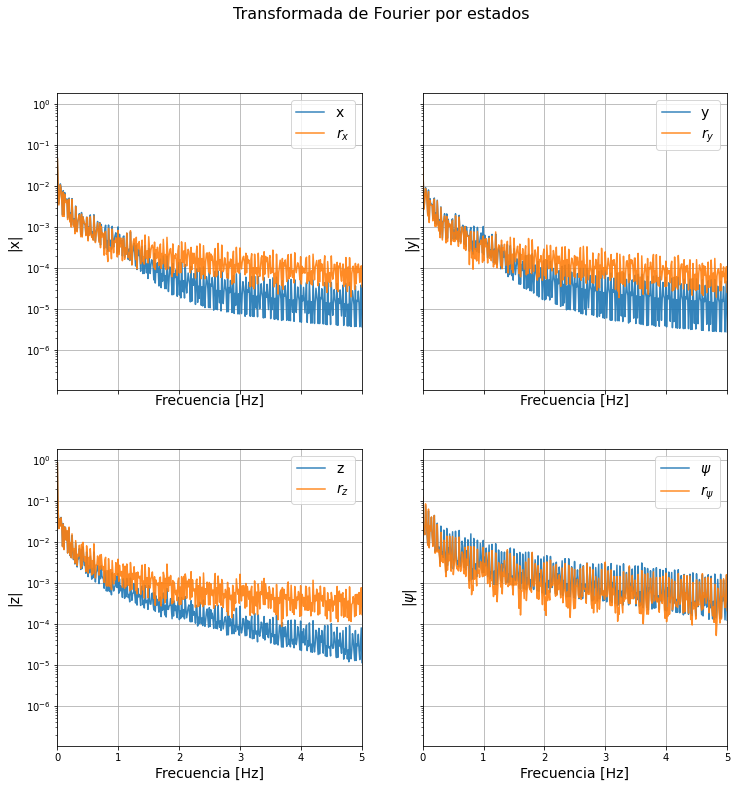

In [36]:
states_list = ['x', 'y', 'z', 'r']
control_list = ['ux', 'uy', 'uz', 'ur']
n_bins = 10000
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
fontsize = 14
#axs[0].set_title('Fourier Transform Histogram per State')
for i, ax in enumerate(axs.flat):
    state = states_list[i]
    st_label = state
    cn_label = r'$r_{'+state+'}$'
    if state=='r':
        st_label = r'$\psi$'
        cn_label = r'$r_{\psi}$'
    hist, bins = np.histogram(F[state]['X'], bins=n_bins, weights=((F[state]['Y']+1e-7)/len(Fourier)))
    ax.plot(bins[:-1], hist, label=st_label, alpha = 0.9)
    control = control_list[i]
    hist, bins = np.histogram(F[control]['X'], bins=n_bins, weights=((F[control]['Y']+1e-7)/len(Fourier)))
    ax.plot(bins[:-1], hist, label=cn_label, alpha = 0.9)
    
    ax.set_ylabel(f'|{st_label}|', fontsize = fontsize)
    ax.set_xlabel('Frecuencia [Hz]', fontsize = fontsize)
    ax.legend(loc='upper right', fontsize = fontsize)
    ax.set_xlim(0, 5)
    ax.grid()
    ax.set_yscale('log')
fig.suptitle('Transformada de Fourier por estados', fontsize=fontsize+2)
plt.savefig("../Imágenes/Fourier_States.svg")

### Análisis de Características - Método Estático

In [22]:
df_total = pd.concat(dfs)

#### Diagrama de caja

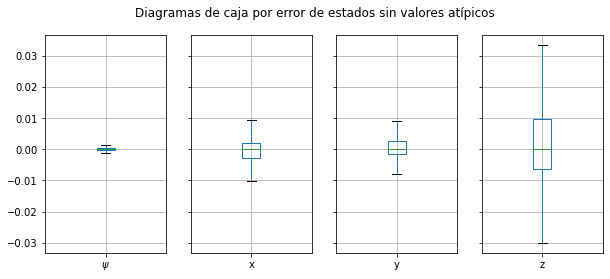

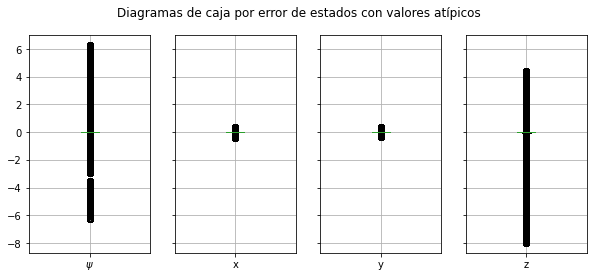

In [35]:
control_list = list(traj_dict.keys())
ref_list = ['u'+t for t in list(traj_dict.keys())]
dic={}
for i in range(len(control_list)):
    dic[ref_list[i]]=control_list[i]     
    
df_refs=df_total[ref_list]
df_controls = df_total[control_list]
#df_controls=df_controls.rename(columns={'r':r'$\psi$'})
df_refs = df_refs.rename(columns=dic)
df_error= df_refs-df_controls
df_error=df_error.rename(columns={'r':r'$\psi$'})
control_list[0]=r'$\psi$'

size = (10, 4)
fig, axs = plt.subplots(1, len(control_list), figsize=size, sharey=True)
fig.suptitle('Diagramas de caja por error de estados sin valores atípicos')
for i in range(len(control_list)):
    df_error.boxplot(control_list[i], ax=axs[i],  showfliers=False)

plt.savefig("../Imágenes/Box1.png")
fig, axs = plt.subplots(1, len(control_list), figsize=size, sharey=True)
fig.suptitle('Diagramas de caja por error de estados con valores atípicos')
for i in range(len(control_list)):
    df_error.boxplot(control_list[i], ax=axs[i])

plt.savefig("../Imágenes/Box2.png")
# fig = plt.figure(figsize=size)
# fig.suptitle('Box plots error by state with outliers')
# df_total.boxplot(control_list+ref_list)

del df_refs
del df_controls
#del df_error

In [40]:
df_error.describe()

,r,x,y,z
count,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06
mean,4.627969e-04,8.758021e-05,-2.146798e-04,8.167065e-03
std,2.383715e-01,3.276864e-02,3.004811e-02,2.330717e-01
min,-6.280259e+00,-4.571175e-01,-3.451859e-01,-8.001762e+00
25%,-3.182027e-04,-2.834105e-03,-1.548836e-03,-6.298987e-03
50%,1.568055e-08,-1.450361e-05,3.140398e-05,1.278477e-04
75%,3.091947e-04,2.028800e-03,2.663405e-03,9.545310e-03
max,6.280775e+00,3.888411e-01,3.772181e-01,4.417104e+00


#### Mapa de Correlación

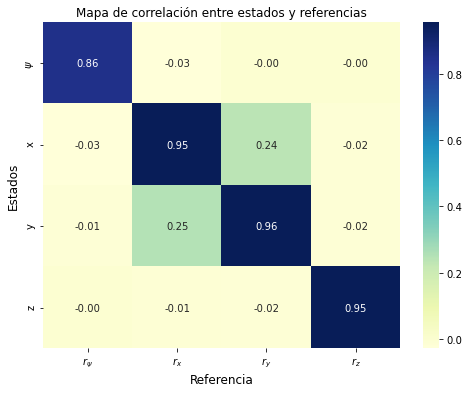

In [39]:
fig = plt.figure(figsize=(8, 6))
fontsize=12
control_list = list(traj_dict.keys())
ref_list = ['u'+t for t in list(traj_dict.keys())]
#correlation = df_total[states_list+rpm_list].corr() #corr() method of pandas library calculates correlation between columns of dataframe
correlation = df_total[control_list+ref_list].corr()
correlation = correlation.rename(columns={'ur':r'$r_{\psi}$', 'uz':r'$r_z$', 'uy':r'$r_y$', 'ux':r'$r_x$'}, index={'r':r'$\psi$'})
sns.heatmap(correlation.iloc[0:4, 4:8],cmap="YlGnBu",annot=True, fmt=".2f")
plt.title("Mapa de correlación entre estados y referencias",fontsize=fontsize)
plt.ylabel("Estados", fontsize=fontsize)
plt.xlabel("Referencia", fontsize=fontsize)
plt.savefig("../Imágenes/Correlation.svg")
plt.show()

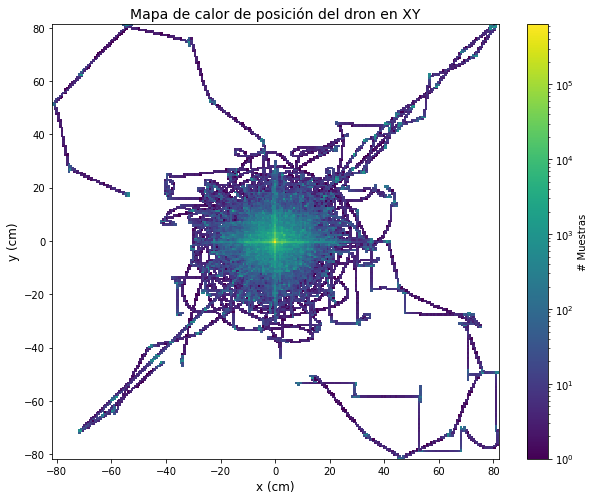

In [50]:
m = 100
bins = 255
fontsize=12
fig, (ax1) = plt.subplots(figsize=(10, 8))
rang = [[m*df_total['x'].describe()['min'], m*df_total['x'].describe()['max']],
       [m*df_total['y'].describe()['min'],m*df_total['y'].describe()['max']]]
h = ax1.hist2d(m*df_total['x'],m*df_total['y'], bins=bins, norm=LogNorm(), range=rang)
fig.colorbar(h[3], ax=ax1, label='# Muestras')
ax1.set_xlabel('x (cm)', fontsize=12)
ax1.set_ylabel('y (cm)', fontsize=12)
ax1.set_title('Mapa de calor de posición del dron en XY', fontsize=14)
#plt.savefig("../Imágenes/Heatxy.svg")
plt.savefig("../Imágenes/Heatxy.png")
# h = ax1.hist2d(m*df_error['x'],m*df_error['y'], bins=bins, norm=LogNorm(), range=rang)
# fig.colorbar(h[3], ax=ax2, label='steps')
# ax2.set_xlabel('x (cm)')
# ax2.set_ylabel('y (cm)')
# _=ax2.set_title('Drone Position Error')

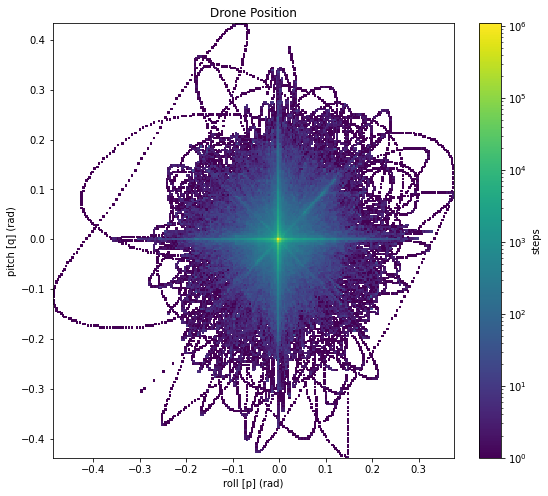

In [51]:
fig, ax = plt.subplots(figsize=(9, 8))
h = ax.hist2d(df_total['p'],df_total['q'], bins=bins, norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='steps')
ax.set_xlabel('roll [p] (rad)')
ax.set_ylabel('pitch [q] (rad)')
_=ax.set_title('Drone Position')

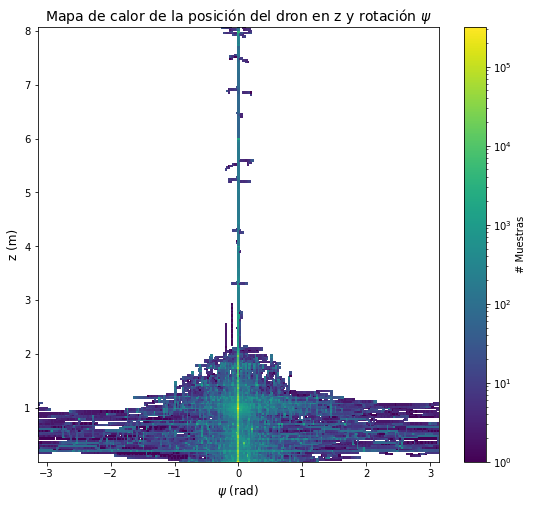

In [52]:
fig, ax = plt.subplots(figsize=(9, 8))
h = ax.hist2d(df_total['r'],df_total['z'], bins=bins, norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='# Muestras')
ax.set_xlabel('$\psi$ (rad)', fontsize=12)
ax.set_ylabel('z (m)', fontsize=12)
_=ax.set_title(r'Mapa de calor de la posición del dron en z y rotación $\psi$', fontsize=14)
#plt.savefig("../Imágenes/Heatrz.svg")
plt.savefig("../Imágenes/Heatrz.png")

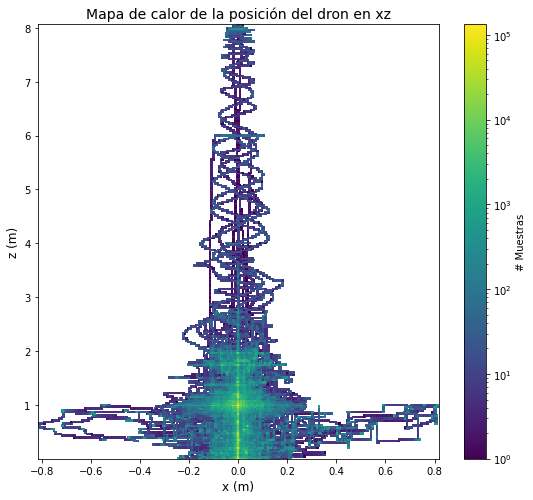

In [53]:
fig, ax = plt.subplots(figsize=(9, 8))
h = ax.hist2d(df_total['x'],df_total['z'], bins=bins, norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='# Muestras')
ax.set_xlabel('x (m)', fontsize=12)
ax.set_ylabel('z (m)', fontsize=12)
_=ax.set_title(r'Mapa de calor de la posición del dron en xz', fontsize=14)
#plt.savefig("../Imágenes/Heatxz.svg")
plt.savefig("../Imágenes/Heatxz.png")

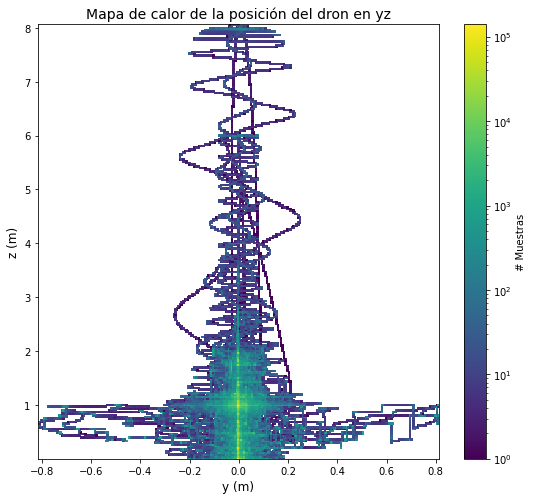

In [54]:
fig, ax = plt.subplots(figsize=(9, 8))
h = ax.hist2d(df_total['y'],df_total['z'], bins=bins, norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='# Muestras')
ax.set_xlabel('y (m)', fontsize=12)
ax.set_ylabel('z (m)', fontsize=12)
_=ax.set_title(r'Mapa de calor de la posición del dron en yz', fontsize=14)
#plt.savefig("../Imágenes/Heatyz.svg")
plt.savefig("../Imágenes/Heatyz.png")

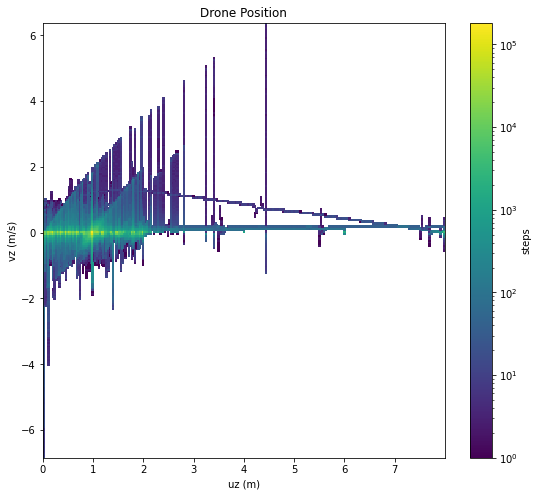

In [47]:
fig, ax = plt.subplots(figsize=(9, 8))
h = ax.hist2d(df_total['uz'],df_total['vz'], bins=bins, norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='steps')
ax.set_xlabel('uz (m)')
ax.set_ylabel('vz (m/s)')
_=ax.set_title('Drone Position')

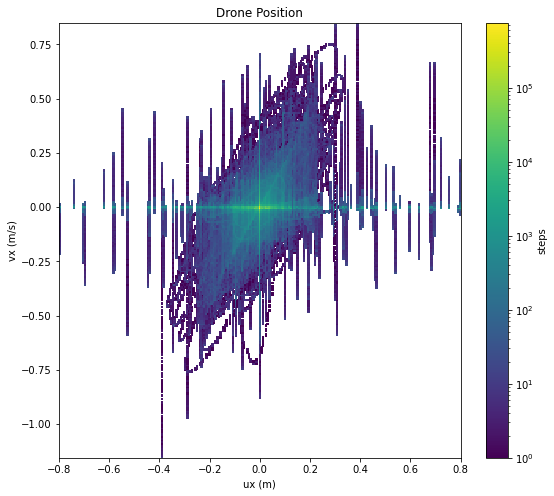

In [29]:
fig, ax = plt.subplots(figsize=(9, 8))
h = ax.hist2d(df_total['ux'],df_total['vx'], bins=bins, norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='steps')
ax.set_xlabel('ux (m)')
ax.set_ylabel('vx (m/s)')
_=ax.set_title('Drone Position')

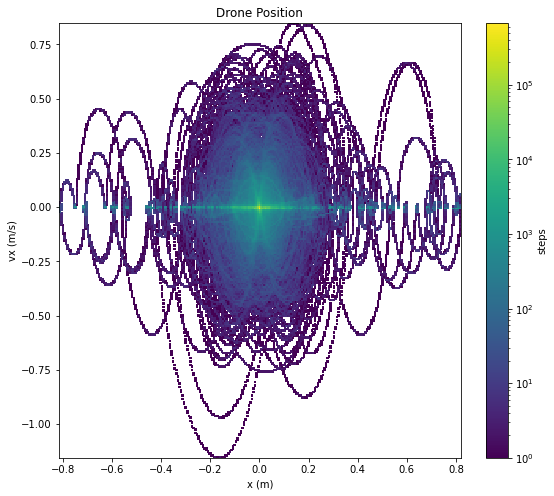

In [30]:
fig, ax = plt.subplots(figsize=(9, 8))
h = ax.hist2d(df_total['x'],df_total['vx'], bins=bins, norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='steps')
ax.set_xlabel('x (m)')
ax.set_ylabel('vx (m/s)')
_=ax.set_title('Drone Position')

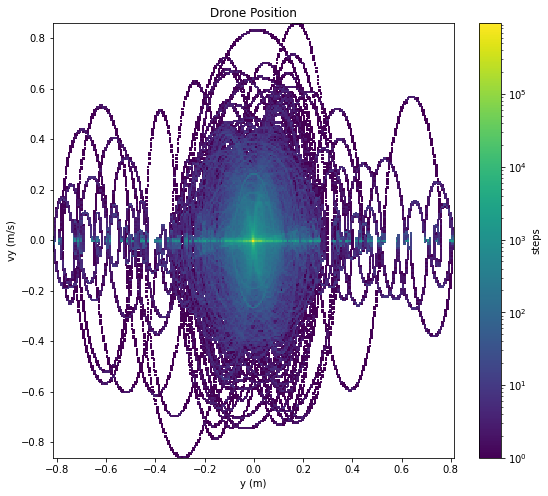

In [31]:
fig, ax = plt.subplots(figsize=(9, 8))
h = ax.hist2d(df_total['y'],df_total['vy'], bins=bins, norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='steps')
ax.set_xlabel('y (m)')
ax.set_ylabel('vy (m/s)')
_=ax.set_title('Drone Position')

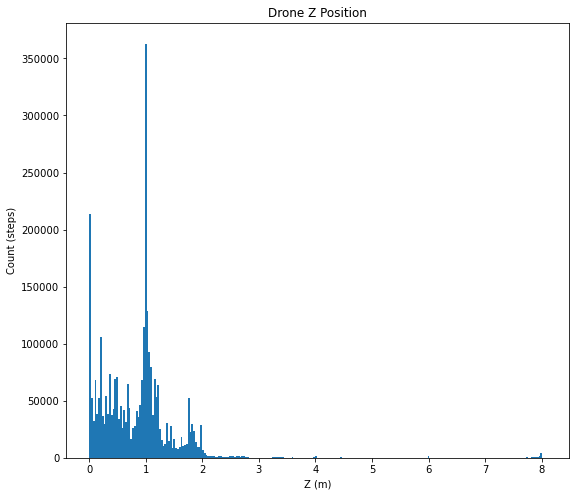

In [32]:
fig, ax = plt.subplots(figsize=(9, 8))
h = ax.hist(df_total['z'], bins=bins)
ax.set_xlabel('Z (m)')
ax.set_ylabel('Count (steps)')
_=ax.set_title('Drone Z Position')

<ipython-input-137-795bdfe0bb1d>:6: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


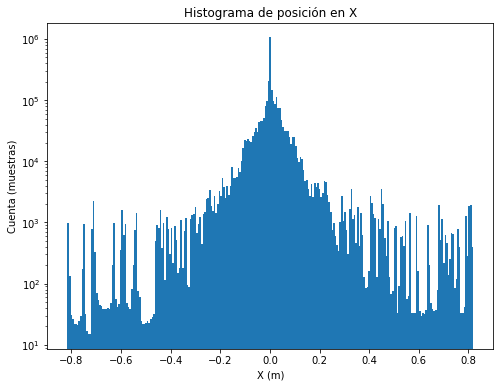

In [137]:
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.hist(df_total['x'], bins=bins)
ax.set_xlabel(f'X (m)')
ax.set_ylabel('Cuenta (muestras)')
_=ax.set_title('Histograma de posición en X')
plt.yscale('log', nonposy='clip')
plt.savefig("../Imágenes/Heatx.svg")

<ipython-input-138-71d4599179a1>:6: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


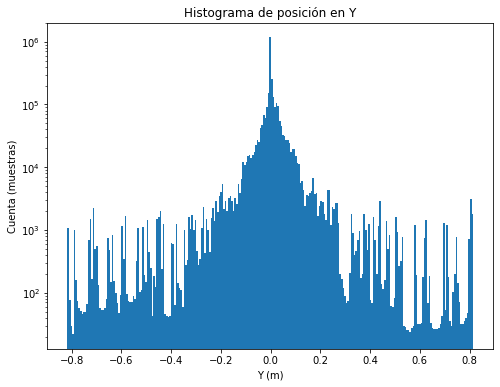

In [138]:
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.hist(df_total['y'], bins=bins)
ax.set_xlabel(f'Y (m)')
ax.set_ylabel('Cuenta (muestras)')
_=ax.set_title('Histograma de posición en Y')
plt.yscale('log', nonposy='clip')
plt.savefig("../Imágenes/Heaty.svg")

<ipython-input-139-cef6a01f9f57>:6: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


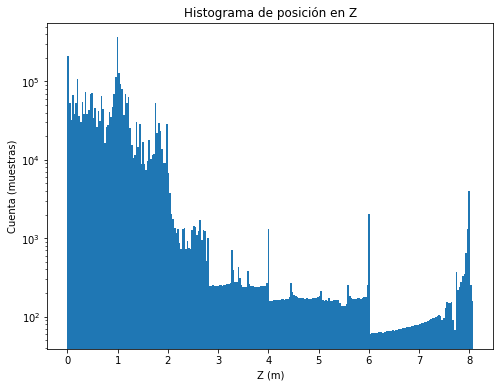

In [139]:
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.hist(df_total['z'], bins=bins)
ax.set_xlabel('Z (m)')
ax.set_ylabel('Cuenta (muestras)')
_=ax.set_title('Histograma de posición en Z')
plt.yscale('log', nonposy='clip')
plt.savefig("../Imágenes/Heatz.svg")

<ipython-input-140-27589bc04f9f>:6: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


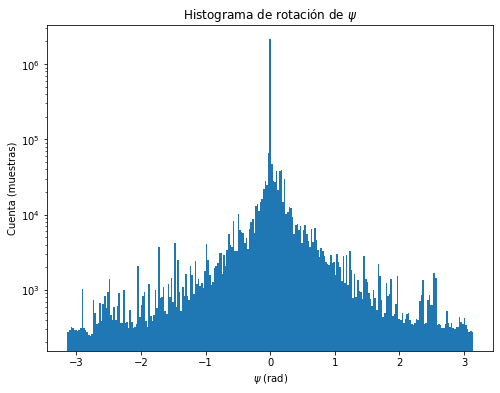

In [140]:
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.hist(df_total['r'], bins=bins)
ax.set_xlabel(f'$\psi$ (rad)')
ax.set_ylabel('Cuenta (muestras)')
_=ax.set_title('Histograma de rotación de $\psi$')
plt.yscale('log', nonposy='clip')
plt.savefig("../Imágenes/Heatr.svg")

In [35]:
df['z']

0        1.770684
1        1.770527
2        1.770384
3        1.770253
4        1.770136
           ...   
23994    1.770739
23995    1.770741
23996    1.770742
23997    1.770744
23998    1.770745
Name: z, Length: 23999, dtype: float64

### Determinar tamaño de la ventana de entrenamiento

#### Basado en la autocorrelación parcial para X, Y, Z y Yaw

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from threading import Thread, Lock
import multiprocessing

In [37]:
workers =  multiprocessing.cpu_count()
N = len(data)
workstep =  np.floor(N/workers)
nlags = 100
pacf_df_x = pd.DataFrame()
pacf_df_y = pd.DataFrame()
pacf_df_z = pd.DataFrame()
pacf_df_r = pd.DataFrame()
threads = []
signals_x = np.array([df['x'].to_numpy() for df in dfs])
signals_y = np.array([df['y'].to_numpy() for df in dfs])
signals_z = np.array([df['z'].to_numpy() for df in dfs])
signals_r = np.array([df['r'].to_numpy() for df in dfs])
n = N%workers
mutex = Lock()

<ipython-input-37-f6126a3019b6>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  signals_x = np.array([df['x'].to_numpy() for df in dfs])
<ipython-input-37-f6126a3019b6>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  signals_y = np.array([df['y'].to_numpy() for df in dfs])
<ipython-input-37-f6126a3019b6>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

In [38]:
def calc_pacf(ini, final, signals, ax):
    global pacf_df_z
    global pacf_df_y
    global pacf_df_x
    global pacf_df_r
    global mutex
    for i in range(int(ini), int(final)):
        pacf_s = pacf(signals[i], nlags=nlags)
        mutex.acquire()                            # Multithread Synchronization
        if ax=='x':
            pacf_df_x[str(int(i))] = pacf_s
        elif ax=='y':
            pacf_df_y[str(int(i))] = pacf_s
        elif ax=='z':
            pacf_df_z[str(int(i))] = pacf_s
        else:
            pacf_df_r[str(int(i))] = pacf_s
        mutex.release()

Pacf X

In [39]:
%%time
for i in range(workers):
    if i<n:
        ini = i*(workstep+1)
        final = ini+(workstep+1)
    else:
        ini = i*(workstep+1)+(n-i)
        final = ini+(workstep)
    if i==workers-1:
        final=len(signals_x)
    t = Thread(target=calc_pacf, name=f'{i}', args=(ini,final, signals_x, 'x'))
    threads.append(t)
    t.start()        
for t in threads:
    t.join()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Wall time: 29.3 s


Pacf Y

In [40]:
%%time
for i in range(workers):
    if i<n:
        ini = i*(workstep+1)
        final = ini+(workstep+1)
    else:
        ini = i*(workstep+1)+(n-i)
        final = ini+(workstep)
    if i==workers-1:
        final=len(signals_x)
    t = Thread(target=calc_pacf, name=f'{i}', args=(ini,final, signals_y, 'y'))
    threads.append(t)
    t.start()        
for t in threads:
    t.join()

Wall time: 30 s


Pacf Z

In [41]:
%%time
for i in range(workers):
    if i<n:
        ini = i*(workstep+1)
        final = ini+(workstep+1)
    else:
        ini = i*(workstep+1)+(n-i)
        final = ini+(workstep)
    if i==workers-1:
        final=len(signals_x)
    t = Thread(target=calc_pacf, name=f'{i}', args=(ini,final, signals_z, 'z'))
    threads.append(t)
    t.start()        
for t in threads:
    t.join()

Wall time: 34.5 s


Pacf r

In [42]:
%%time
for i in range(workers):
    if i<n:
        ini = i*(workstep+1)
        final = ini+(workstep+1)
    else:
        ini = i*(workstep+1)+(n-i)
        final = ini+(workstep)
    if i==workers-1:
        final=len(signals_x)
    t = Thread(target=calc_pacf, name=f'{i}', args=(ini,final, signals_r, 'r'))
    threads.append(t)
    t.start()        
for t in threads:
    t.join()

Wall time: 29.6 s


In [145]:
pacf_sx = np.abs(pacf_df_x.T.mean())
pacf_sy = np.abs(pacf_df_y.T.mean())
pacf_sz = np.abs(pacf_df_z.T.mean())
pacf_sr = np.abs(pacf_df_r.T.mean())

pacf_sx/=np.max(pacf_sx)
pacf_sy/=np.max(pacf_sy)
pacf_sz/=np.max(pacf_sz)
pacf_sr/=np.max(pacf_sr)
pacf_sm_hat = np.mean([pacf_sx, pacf_sy, pacf_sz, pacf_sr], axis=0)

In [146]:
import matplotlib.patches as mpatches
from scipy.signal import savgol_filter
pacf_sx_hat = np.clip(savgol_filter(pacf_sx, 15, 11, mode='interp'), 0,1)
pacf_sy_hat = np.clip(savgol_filter(pacf_sy, 15, 11, mode='interp'), 0,1)
pacf_sz_hat = np.clip(savgol_filter(pacf_sz, 15, 11, mode='interp'), 0,1)
pacf_sr_hat = np.clip(savgol_filter(pacf_sr, 15, 11, mode='interp'), 0,1)
pacf_sm_hat = np.mean([pacf_sx_hat, pacf_sy_hat, pacf_sz_hat, pacf_sr_hat], axis=0)

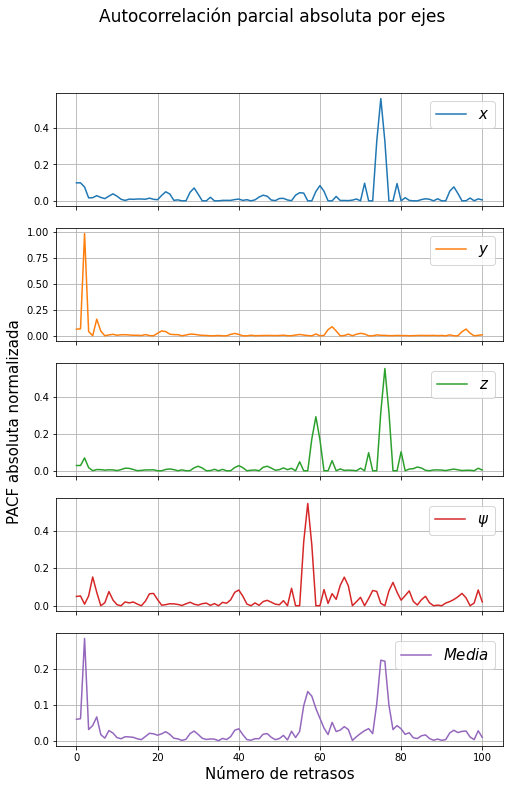

In [147]:
fig, axs = plt.subplots(5,1, figsize=(8,12), sharex=True)
axs[0].plot(pacf_sx_hat, label='$x$', color='tab:blue')
axs[1].plot(pacf_sy_hat, label='$y$',color='tab:orange')
axs[2].plot(pacf_sz_hat, label='$z$', color='tab:green')
axs[3].plot(pacf_sr_hat, label='$\psi$', color='tab:red')
axs[4].plot(pacf_sm_hat, label='$Media$', color='tab:purple')
axs[4].set_xlabel("Número de retrasos", fontsize=fontSize)

for i, ax in enumerate(axs):
    axs[i].legend(loc="upper right", fontsize=fontSize)
    axs[i].grid()

_=fig.text(0.04, 0.5, 'PACF absoluta normalizada', va='center', rotation='vertical', fontsize=fontSize)
fig.suptitle('Autocorrelación parcial absoluta por ejes', fontsize=fontSize+2)
plt.savefig("../Imágenes/pacf.svg")

In [148]:
print((-pacf_sx).argsort()[:7])
print((-pacf_sy).argsort()[:7])
print((-pacf_sz).argsort()[:7])
print((-pacf_sr).argsort()[:7])
print((-pacf_sm_hat).argsort()[:7])

0    75
1    60
2    93
3    29
4     0
5     1
6     2
dtype: int64
0     2
1    63
2     5
3    96
4    21
5     0
6     1
dtype: int64
0    76
1    59
2     2
3    40
4    47
5    30
6    84
dtype: int64
0    57
1    66
2     4
3    78
4    40
5    63
6    95
dtype: int64
[ 2 75 76 57 58 74 77]


In [149]:
pacf_s.sort_values(ascending=False).head()

57    20.059528
66     4.950823
4      4.255407
78     3.250315
40     3.081983
dtype: float64

In [152]:
64/240

0.26666666666666666

In [154]:
763/3

254.33333333333334